# Image Classification

For this problem, we will MNIST dataset.
http://yann.lecun.com/exdb/mnist/

In [1]:
spark.sparkContext.uiWebUrl

'http://172.17.1.79:4040'

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [10]:
df_training = (spark
               .read
               .options(header = False, inferSchema = True)
               .csv("data/MNIST/mnist_train.csv"))

In [71]:
df_training.count()

60000

In [14]:
print("No of columns: ", len(df_training.columns), df_training.columns)

No of columns:  785 ['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13', '_c14', '_c15', '_c16', '_c17', '_c18', '_c19', '_c20', '_c21', '_c22', '_c23', '_c24', '_c25', '_c26', '_c27', '_c28', '_c29', '_c30', '_c31', '_c32', '_c33', '_c34', '_c35', '_c36', '_c37', '_c38', '_c39', '_c40', '_c41', '_c42', '_c43', '_c44', '_c45', '_c46', '_c47', '_c48', '_c49', '_c50', '_c51', '_c52', '_c53', '_c54', '_c55', '_c56', '_c57', '_c58', '_c59', '_c60', '_c61', '_c62', '_c63', '_c64', '_c65', '_c66', '_c67', '_c68', '_c69', '_c70', '_c71', '_c72', '_c73', '_c74', '_c75', '_c76', '_c77', '_c78', '_c79', '_c80', '_c81', '_c82', '_c83', '_c84', '_c85', '_c86', '_c87', '_c88', '_c89', '_c90', '_c91', '_c92', '_c93', '_c94', '_c95', '_c96', '_c97', '_c98', '_c99', '_c100', '_c101', '_c102', '_c103', '_c104', '_c105', '_c106', '_c107', '_c108', '_c109', '_c110', '_c111', '_c112', '_c113', '_c114', '_c115', '_c116', '_c117', '_c118', '_c119', '_c120', 

In [18]:
feature_culumns = ["_c" + str(i+1) for i in range(784)]
print(feature_culumns)

['_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13', '_c14', '_c15', '_c16', '_c17', '_c18', '_c19', '_c20', '_c21', '_c22', '_c23', '_c24', '_c25', '_c26', '_c27', '_c28', '_c29', '_c30', '_c31', '_c32', '_c33', '_c34', '_c35', '_c36', '_c37', '_c38', '_c39', '_c40', '_c41', '_c42', '_c43', '_c44', '_c45', '_c46', '_c47', '_c48', '_c49', '_c50', '_c51', '_c52', '_c53', '_c54', '_c55', '_c56', '_c57', '_c58', '_c59', '_c60', '_c61', '_c62', '_c63', '_c64', '_c65', '_c66', '_c67', '_c68', '_c69', '_c70', '_c71', '_c72', '_c73', '_c74', '_c75', '_c76', '_c77', '_c78', '_c79', '_c80', '_c81', '_c82', '_c83', '_c84', '_c85', '_c86', '_c87', '_c88', '_c89', '_c90', '_c91', '_c92', '_c93', '_c94', '_c95', '_c96', '_c97', '_c98', '_c99', '_c100', '_c101', '_c102', '_c103', '_c104', '_c105', '_c106', '_c107', '_c108', '_c109', '_c110', '_c111', '_c112', '_c113', '_c114', '_c115', '_c116', '_c117', '_c118', '_c119', '_c120', '_c121', '_c122', '_c123', 

In [19]:
from pyspark.ml.feature import VectorAssembler

In [20]:
vectorizer = VectorAssembler(inputCols=feature_culumns, outputCol="features")
training = (vectorizer
            .transform(df_training)
            .select("_c0", "features")
            .toDF("label", "features")
            .cache())
training.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    5|(784,[152,153,154...|
|    0|(784,[127,128,129...|
|    4|(784,[160,161,162...|
|    1|(784,[158,159,160...|
|    9|(784,[208,209,210...|
|    2|(784,[155,156,157...|
|    1|(784,[124,125,126...|
|    3|(784,[151,152,153...|
|    1|(784,[152,153,154...|
|    4|(784,[134,135,161...|
|    3|(784,[123,124,125...|
|    5|(784,[216,217,218...|
|    3|(784,[143,144,145...|
|    6|(784,[72,73,74,99...|
|    1|(784,[151,152,153...|
|    7|(784,[211,212,213...|
|    2|(784,[151,152,153...|
|    8|(784,[159,160,161...|
|    6|(784,[100,101,102...|
|    9|(784,[209,210,211...|
+-----+--------------------+
only showing top 20 rows



In [26]:
a = training.first().features.toArray()
type(a)

numpy.ndarray

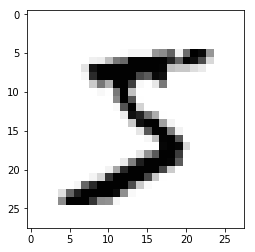

In [29]:
plt.imshow(a.reshape(28, 28), cmap="Greys")

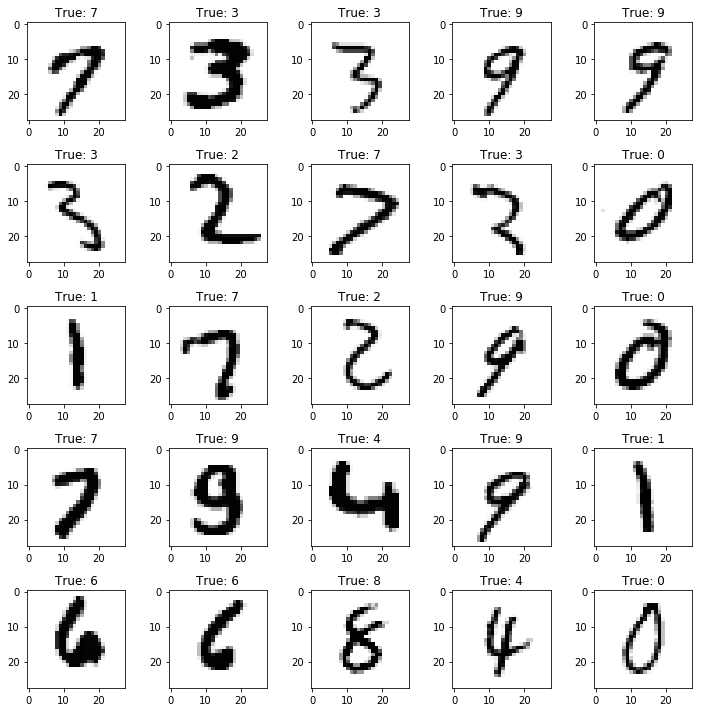

In [40]:
images = training.sample(False, 0.01, 1).take(25)
fig, _ = plt.subplots(5, 5, figsize = (10, 10))
for i, ax in enumerate(fig.axes):
    r = images[i]
    label = r.label
    features = r.features
    ax.imshow(features.toArray().reshape(28, 28), cmap = "Greys")
    ax.set_title("True: " + str(label))

plt.tight_layout()
    

In [74]:
counts = training.groupBy("label").count()

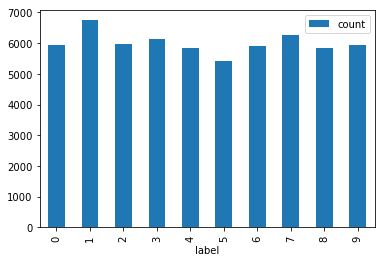

In [76]:
counts_df = counts.rdd.map(lambda r: {"label": r['label'], 
                                     "count": r['count']}).collect()
pd.DataFrame(counts_df).set_index("label").sort_index().plot.bar()

In [55]:
df_testing = (spark
              .read
              .options(header = False, inferSchema = True)
              .csv("data/MNIST/mnist_test.csv"))
testing = (vectorizer
           .transform(df_testing)
           .select("_c0", "features")
           .toDF("label", "features")
           .cache())

In [56]:
from pyspark.ml.classification import LogisticRegression

In [57]:
lr = LogisticRegression(featuresCol="features", 
                        labelCol="label", 
                        regParam=0.1, 
                        elasticNetParam=0.1, 
                        maxIter=10000)

In [58]:
lr_model = lr.fit(training)

In [65]:
from pyspark.sql.functions import *

In [67]:
test_pred = lr_model.transform(testing).withColumn("matched", expr("label == prediction"))
test_pred.show()

+-----+--------------------+--------------------+--------------------+----------+-------+
|label|            features|       rawPrediction|         probability|prediction|matched|
+-----+--------------------+--------------------+--------------------+----------+-------+
|    7|(784,[202,203,204...|[0.08070480165374...|[0.01163236392094...|       7.0|   true|
|    2|(784,[94,95,96,97...|[1.25425406358765...|[0.02467764471716...|       2.0|   true|
|    1|(784,[128,129,130...|[-1.2276524471687...|[0.00751263994471...|       1.0|   true|
|    0|(784,[124,125,126...|[3.71476062530585...|[0.85536145424016...|       0.0|   true|
|    4|(784,[150,151,159...|[-0.2039270192761...|[0.04549113250992...|       4.0|   true|
|    1|(784,[156,157,158...|[-1.8454996939466...|[0.00278444647289...|       1.0|   true|
|    4|(784,[149,150,151...|[-1.7871799792661...|[0.00965258005973...|       4.0|   true|
|    9|(784,[179,180,181...|[-2.3331144616742...|[0.00711927716793...|       9.0|   true|
|    5|(78

In [61]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [62]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", 
                                               predictionCol="prediction", 
                                               metricName="accuracy")

In [63]:
evaluator.evaluate(test_pred)

0.8729

In [70]:
(test_pred
 .withColumn("matched", expr("cast(matched as int)"))
 .groupby("label")
 .agg(avg("matched"))
 .orderBy("label")
 .show())

+-----+------------------+
|label|      avg(matched)|
+-----+------------------+
|    0|0.9622448979591837|
|    1|0.9718061674008811|
|    2|0.8275193798449613|
|    3|0.8772277227722772|
|    4|0.8940936863543788|
|    5|0.7600896860986547|
|    6|0.9050104384133612|
|    7|0.8735408560311284|
|    8|0.7895277207392197|
|    9|0.8453914767096135|
+-----+------------------+



### Classifying MNIST using Neural Networks

In [15]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [16]:
layers = [784, 100, 20, 10]
perceptron = MultilayerPerceptronClassifier(maxIter=1000, layers=layers, blockSize=128, seed=1234)
perceptron_model = perceptron.fit(training)

In [ ]:
from time import time

In [ ]:
start_time = time()
perceptron_model = perceptron.fit(training)
test_pred = perceptron_model.transform(testing)
print("Accuracy:", evaluator.evaluate(test_pred))
print("Time taken: %d" % (time() - start_time))